# Метод ближайших соседей

Для начала подключим библиотеки, которые нам понадобятся.

In [1]:
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

В качестве исходных данных возьмём https://www.kaggle.com/rajyellow46/wine-quality.

Эти два набора данных относятся к красному и белому вариантам португальского вина "Винью Верде". Из-за проблем с конфиденциальностью и логистикой доступны только физико-химические (исходные) и сенсорные (выходные) переменные (например, нет данных о сортах винограда, марке вина, цене продажи вина и т.д.).

Загрузим данные из csv файла.

In [2]:
data = pd.read_csv('winequalityN.csv')
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


Так как исходные данные используют буквенные обозначения для обозначений в поле "type" необходимо совершить предобработку данных, а именно - поставим прямое соответствие "слово-цифра". С помощью LabelEncoder выполним это кодирование для столбца "type".

In [4]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
data["type"] = labelencoder.fit_transform(data["type"])
#1 - white, 0 - red
 
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Проверим есть ли пропуски

In [5]:
data.isna().any()

type                    False
fixed acidity            True
volatile acidity         True
citric acid              True
residual sugar           True
chlorides                True
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                       True
sulphates                True
alcohol                 False
quality                 False
dtype: bool

In [6]:
data.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

Удалим все NaN (В последующих лабах будем заменять на среднее по тренировочной выборке, но это же первая лаба)

In [7]:
data.dropna(axis=0, inplace=True)

In [8]:
data.isnull().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Так как пропусков нет - идём дальше.
Посмотрим корреляцию признаков между собой. Построим графическое представление модуля значения корреляции попарно между признаками. Для удобства выведем числовые значения корреляции.

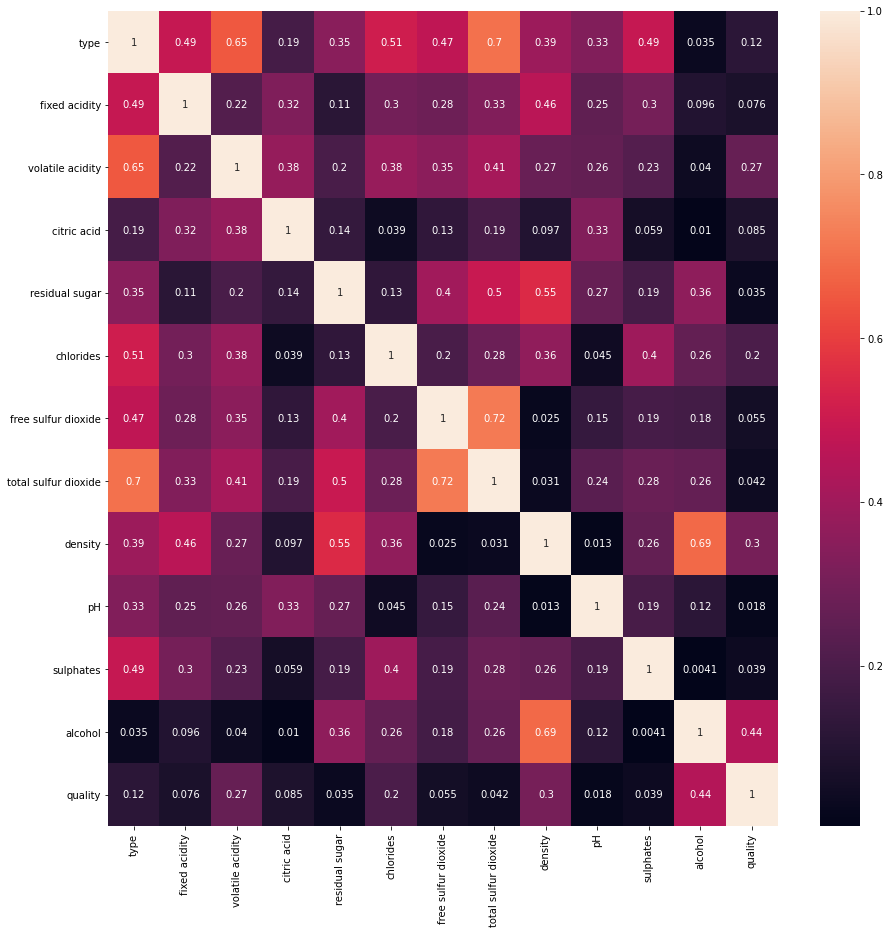

In [9]:
corr = data.corr().abs()
plt.figure(figsize=(15,15))
sns.heatmap(corr,annot=True)

In [10]:
np.corrcoef(data['alcohol'], data['type'])

array([[1.        , 0.03509537],
       [0.03509537, 1.        ]])

In [11]:
np.corrcoef(data['quality'], data['type'])

array([[1.        , 0.11918495],
       [0.11918495, 1.        ]])

Заметим что "quality" (оценка сомелье) и "alcohol" (процентное содержание алкоголя) не влияют на цвет вина. Удалим эти критерии.

In [12]:
data = data.drop(['alcohol', 'quality'], axis='columns')

Данные готовы, укажем "type" (тип вина) в качестве целевой переменной.
и всё остальные критерии в качестве X.

In [13]:
X = data[data.columns[1:]]
y = data["type"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

Создадим классификатор с количеством ближайших соседей равном 5 и выведем Score.

In [14]:
from sklearn.neighbors import KNeighborsClassifier

# создадим наш классификатор. Гиперпараметр у этого алгоритма один - количество соседей.
clf = KNeighborsClassifier(n_neighbors=5)
# обучим классификатор на тренировочной выборке
fitData = clf.fit(X_train, y_train)
# подсчитаем долю верных ответов алгоритма на тестовой выборке.
# Есть и другие метрики качества - о них будет рассказано на следующей лабе
scoreData = clf.score(X_test, y_test)
print("Score: {}".format(scoreData))

Score: 0.9362623762376238


Переберем количество соседей от 1 до 40 и построим графики

In [15]:
# Создадим пустой словарь. Будем добавлять в него значения наших "скоров". Ключами будет значение гиперпараметра,
# значениями - качество работы. Рассмотрим отдельно качество на тренировочной выборке и на тестовой.
train_scores = {}
test_scores = {}

for n in range(1, 41):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X_train, y_train)
    # значение качества на текущей итерации и запишем его в наши словари
    train_scores.update( {n: clf.score(X_train, y_train)} )
    test_scores.update(  {n: clf.score(X_test, y_test)}   )


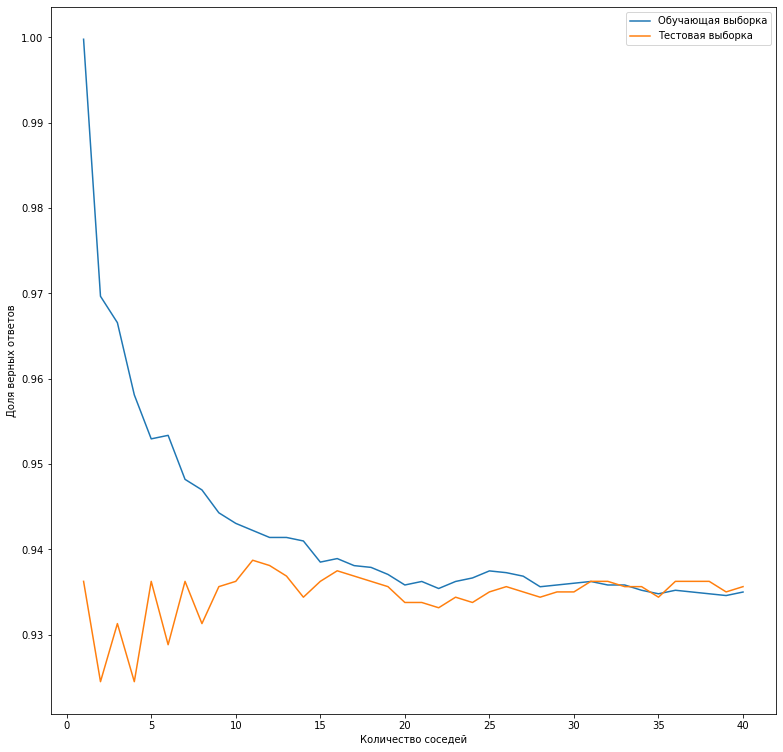

In [16]:
# нарисуем графики
plt.figure(figsize=(13,13))
plt.plot(list(train_scores.keys()), list(train_scores.values()), label='Обучающая выборка')
plt.plot(list(test_scores.keys()), list(test_scores.values()), label='Тестовая выборка')
plt.xlabel('Количество соседей')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()